In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage.measure import regionprops

In [2]:
path_to_melanoma_ims = 'data/training_data/melanoma/images/'
path_to_melanoma_masks = 'data/training_data/melanoma/masks/'
path_to_keratosis_ims = 'data/training_data/keratosis/images/'
path_to_keratosis_masks = 'data/training_data/keratosis/masks/'

In [3]:
melanoma_im_list = os.listdir(path_to_melanoma_ims)
keratosis_im_list = os.listdir(path_to_keratosis_ims)

You probably want to put this functions inside a separate module that you can import, something called for instance ``extract_features_from_skin_image``. Note that this functions accept a ``skin_image`` object.

In [4]:
def compute_eccentricity(skin_image):
    '''
    This function expects a skin_image object, which contains a mask with the lesion boundary
    '''
    regions = regionprops(skin_image.mask.astype(int), cache=False) # avoids computing all props
    return regions[0].eccentricity

def compute_diameter(skin_image):
    '''
    This function expects a skin_image object, which contains a mask with the lesion boundary
    '''
    regions = regionprops(skin_image.mask.astype(int), cache=False) # avoids computing all props
    return regions[0].equivalent_diameter

This is the defintion of a ``skin_image object``. It holds the relevant data (image, binary mask with lesion area, and diagnosis - groundtruth). These are loaded at instanatiation time by the constructor, thanks to the image name, which is passed as a parameter. The relative path to the data is a global variable defined above.

In [5]:
class skin_image:   
    def __init__(self, name, diagnosis):
        self.name = name
        if diagnosis == 'melanoma':
            path_ims = path_to_melanoma_ims
            path_masks = path_to_melanoma_masks
        elif diagnosis == 'keratosis':
            path_ims = path_to_keratosis_ims
            path_masks = path_to_keratosis_masks
        elif diagnosis == 'unkown':
            # this is for test images
            path_ims = path_to_test_ims
            path_masks = path_to_test_masks
        else:
            print('invalid diagnosis')
        
        self.image = io.imread(path_ims+name)
        self.mask = io.imread(path_masks+name[:-4]+'.png', dtype=bool)
        
        # AVAILABLE FEATURES: These are place-holders for features that you may want to compute out of each image
        self.eccentricity = None
        self.diameter = None
        
    # The skin_image object knows how to compute these features. 
    # It does that by calling to the functions defined in the previous cells    
    def load_eccentricity(self):
        # this calls an external function. If the attribute has not been initialized above, this will crash.
        self.eccentricity = compute_eccentricity(self)
    
    def load_diameter(self):
        self.diameter = compute_diameter(self)       

Let us instantiate a `skin_image` object:

**A note of caution:** If some of your features are computationally really expensive to compute, you may want to compute them just once, save them to disk, and write a different load function, like this:

In [6]:
def load_my_fancy_feature(self):
    # my_fancy_eature has been already computed, and stored with the same name as the image 
    # plus an underscore plus the name of the feature
    precomputed_feature_name = self.name[:-4] + '_my_fancy_feature' + '.npy'
    self.my_fancy_feature = np.load(precomputed_feature_name)

See [here](https://stackoverflow.com/a/37996966/3208255) for a simple example on how to load and save numpy arrays to memory.

In [7]:
image = skin_image(melanoma_im_list[0], 'melanoma');

At the moment, this object only holds the data, no feature has been computed:

In [8]:
print(image.eccentricity)

None


We can call the `load_eccentricity` method to compute it:

In [9]:
image.load_eccentricity()

In [10]:
print(image.eccentricity)

0.5933166263219736


Now, you can loop on the training set, load the appropriate features, and build a training set:

In [11]:
nr_melanoma_ims = len(melanoma_im_list)
nr_keratosis_ims = len(keratosis_im_list)
nr_ims = nr_melanoma_ims +  nr_keratosis_ims


nr_features = 2 # eccentricity and diameter

X = np.zeros([nr_ims, nr_features])

for i in range(nr_keratosis_ims):
    im_name = keratosis_im_list[i]
    image = skin_image(im_name, 'keratosis');
    
    # Load eccentricity and diameter
    image.load_eccentricity()
    image.load_diameter()
    
    # Now they are available and we store them in X
    X[i,0] = image.eccentricity
    X[i,1] = image.diameter
    if i%10 == 0:
        print(i+1, '/', nr_ims)  

for i in range(nr_melanoma_ims):
    im_name = melanoma_im_list[i]
    image = skin_image(im_name, 'melanoma');
    
    # Load eccentricity and diameter
    image.load_eccentricity()
    image.load_diameter()
    
    # Now they are available and we store them in X
    X[nr_keratosis_ims + i,0] = image.eccentricity
    X[nr_keratosis_ims + i,1] = image.diameter
    if i%10 == 0:
        print(nr_keratosis_ims + i +1, '/', nr_ims)  

1 / 502
11 / 502
21 / 502
31 / 502
41 / 502
51 / 502
61 / 502
71 / 502
81 / 502
91 / 502
101 / 502
111 / 502
121 / 502
131 / 502
141 / 502
151 / 502
161 / 502
171 / 502
181 / 502
191 / 502
201 / 502
204 / 502
214 / 502
224 / 502
234 / 502
244 / 502
254 / 502
264 / 502
274 / 502
284 / 502
294 / 502
304 / 502
314 / 502
324 / 502
334 / 502
344 / 502
354 / 502
364 / 502
374 / 502
384 / 502
394 / 502
404 / 502
414 / 502
424 / 502
434 / 502
444 / 502
454 / 502
464 / 502
474 / 502
484 / 502
494 / 502


We know that the first `nr_melanoma_ims` were positive examples, so we assign them a one, and we also assign a zero to the keratosis images in our ground-truth vector `y`.

In [12]:
y_melanoma = np.ones(nr_melanoma_ims)
y_keratosis = np.zeros(nr_keratosis_ims)
y = np.hstack([y_melanoma, y_keratosis])

Let us scale the features:

In [13]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

We can visually inspect if these two features are enough to separate the images into melanoma and keratosis

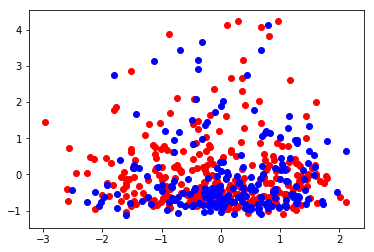

In [14]:
plt.scatter(X[:nr_melanoma_ims,0],X[:nr_melanoma_ims,1], c= 'r')
plt.scatter(X[nr_melanoma_ims:,0],X[nr_melanoma_ims:,1], c= 'b')
plt.show()

We split the training set into a training and a validation set:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

Now we can train, for example, an SVM on the training set, and compute its performance on the validation set:

In [16]:
from sklearn import svm
gamma = 2 # SVM RBF radius
svc_kernel = svm.SVC(kernel='rbf', gamma=gamma, decision_function_shape='ovr', probability=True)
svc_kernel.fit(X_train, y_train)
svc_kernel.score(X_val, y_val)

0.6506024096385542

Not really good. Your goal is to improve this result by designing better (more discriminative) features, and investigating if a better classifier (or this one, by cross-validated to find out a better hyperparameter configuration) can improve performance.

Below you can find some code to visualize the results and do some pretty plots (notice these plots will only be possible with two features (two-dimensional feature space), but it gives you an idea of what is going on above):

In [17]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [18]:
def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.65, **params)


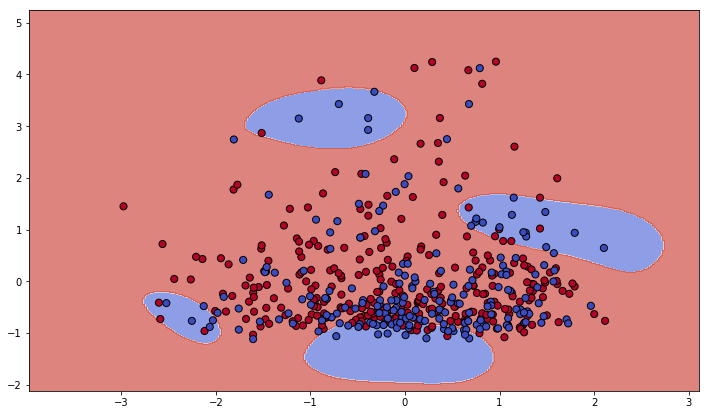

In [19]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plt.figure(figsize=(12,7))
plot_contours(svc_kernel, xx, yy)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
plt.show()

# Computing the Results you need to submit
Once you are happy with the result of your classifier, you need to apply it to build predictions on the test set, for which only me has the result. I expect from you a csv file with the name of the image in the first column, and the predicted diagnosis in the second one. The prediction should be a number in between zero and 1, being 1 that your model is sure of the image containing a melanoma. 

In [20]:
path_to_test_ims = 'data/test_data/images/'
path_to_test_masks = 'data/test_data/masks/'

This is **critical**: the images in the test set must undergo **exactly** the same process as the images you used for training. This involves computing exactly the same features, but also pre-processing the images in exactly the same way (if you are doing some pre-processing), and scaling the features, reducing the dimensionality or whichever other process you have done when training. Your model must see the same description in test than in train time, otherwise the predictions won't make sense!

In [21]:
test_im_list = os.listdir(path_to_test_ims)

nr_test_ims = len(test_im_list)
nr_features = 2 # eccentricity and diameter

X_test = np.zeros([nr_test_ims, nr_features])

for i in range(nr_test_ims):
    im_name = test_im_list[i]
    image = skin_image(im_name, 'unkown');
    
    # Load eccentricity and diameter.
    image.load_eccentricity()
    image.load_diameter()
    
    # Now they are available and we store them in X
    X_test[i,0] = image.eccentricity
    X_test[i,1] = image.diameter
    if i%10 == 0:
        print(i+1, '/', nr_test_ims)  

1 / 126
11 / 126
21 / 126
31 / 126
41 / 126
51 / 126
61 / 126
71 / 126
81 / 126
91 / 126
101 / 126
111 / 126
121 / 126


In [22]:
# Need to do exactly the same pre-processing as while training
X_test = StandardScaler().fit_transform(X_test)

With SVMs, in order to obtain predicted probabilities in the [0,1] interval we need to call their `predict_proba()` method. 

In [23]:
predictions = svc_kernel.predict_proba(X_test)

`predict_proba()` is a method by which a classifier outputs the probability of the instance being in each of the classes, so in this case we want the second column:

In [24]:
# define the name of your group here
group_name = 'adrian_galdran'

with open(group_name+'_solution.csv','w') as file:
    for i in range(nr_test_ims):
        line = im_name + ', ' +str(predictions[i,1])
        print(line)
        file.write(line)
        file.write('\n')

ISIC_0014615.jpg, 0.580259145503
ISIC_0014615.jpg, 0.580417464727
ISIC_0014615.jpg, 0.581146548527
ISIC_0014615.jpg, 0.580255450946
ISIC_0014615.jpg, 0.581043537203
ISIC_0014615.jpg, 0.58034885699
ISIC_0014615.jpg, 0.580729785612
ISIC_0014615.jpg, 0.580710992678
ISIC_0014615.jpg, 0.580359464172
ISIC_0014615.jpg, 0.580263232554
ISIC_0014615.jpg, 0.58023346475
ISIC_0014615.jpg, 0.580451531073
ISIC_0014615.jpg, 0.582029523334
ISIC_0014615.jpg, 0.580368285714
ISIC_0014615.jpg, 0.581221281977
ISIC_0014615.jpg, 0.580995961709
ISIC_0014615.jpg, 0.580346418748
ISIC_0014615.jpg, 0.580387920175
ISIC_0014615.jpg, 0.580321288926
ISIC_0014615.jpg, 0.580473369299
ISIC_0014615.jpg, 0.580415693304
ISIC_0014615.jpg, 0.580707036765
ISIC_0014615.jpg, 0.580747493295
ISIC_0014615.jpg, 0.580324070696
ISIC_0014615.jpg, 0.581840068883
ISIC_0014615.jpg, 0.580533203976
ISIC_0014615.jpg, 0.580363448719
ISIC_0014615.jpg, 0.581871593531
ISIC_0014615.jpg, 0.580648356411
ISIC_0014615.jpg, 0.58031935375
ISIC_0014615.

After receiving your submission, I will compare your predictions with the groundtruth, and send you back an ROC curve and some numerical performance results to include in your final report.